
----------- Benchmark Results -----------
Number of nodes: 162
Number of edges: 878
Collision checks performed: 3141
Path found with length: 54.94
Planning time: 1.35 seconds
------------------------------------------


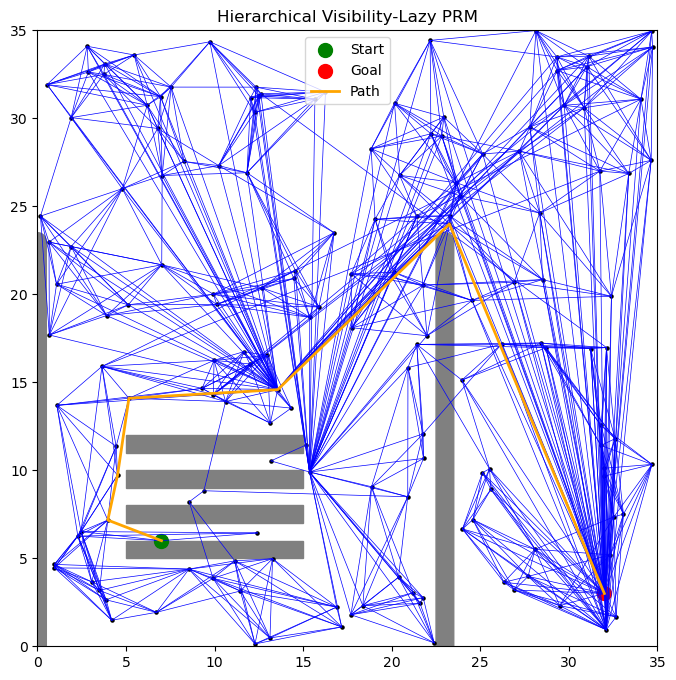

In [14]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString


# ---------- CONFIGURATION ----------
map_bounds = (0, 35, 0, 35)

obstacles = [ Polygon([(5, 5), (15, 5), (15, 6), (5, 6)]),
            Polygon([(5, 7), (15, 7), (15, 8), (5, 8)]),
            Polygon([(5, 9), (15, 9), (15, 10), (5, 10)]),
            Polygon([(5, 11), (15, 11), (15, 12), (5, 12)]),
            LineString([(0, 0), (0, 23)]).buffer(0.5),
             LineString([(23, 0), (23, 23)]).buffer(0.5), ]
num_regions = 4
samples_per_region = 40
lazy_k_neighbors = 8


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = []

    for _ in range(num_samples):
        node = sample_free(region_bounds, obstacles)
        G.add_node(node)
        nodes.append(node)

    for node in nodes:
        distances = [(other, np.linalg.norm(np.subtract(node, other)))
                     for other in nodes if other != node]
        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]

        for neighbor, dist in neighbors:
            G.add_edge(node, neighbor, weight=dist)

    return G


# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph


# ---------- LAZY VALIDATION ----------
def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid


def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None

        if validate_lazy_path(G, path, obstacles):
            return path


# ---------- PLOTTING ----------
def plot_prm(G, obstacles, start=None, goal=None, path=None):
    plt.figure(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')

    # Plot edges
    for (u, v) in G.edges:
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        plt.plot(x, y, color='blue', linewidth=0.5)

    # Plot nodes
    xs, ys = zip(*G.nodes)
    plt.scatter(xs, ys, color='black', s=5)

    # Plot start and goal
    if start:
        plt.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        plt.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Plot path
    if path:
        px, py = zip(*path)
        plt.plot(px, py, color='orange', linewidth=2, label="Path")

    plt.xlim(map_bounds[0], map_bounds[1])
    plt.ylim(map_bounds[2], map_bounds[3])
    plt.legend()
    plt.title("Hierarchical Visibility-Lazy PRM")
    plt.show()


# ---------- MAIN ----------
if __name__ == "__main__":
    start_time = time.time()

    collision_checks = 0  # Reset

    # Build graph
    G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)

    start = (7, 6)
    goal = (32, 3)

    G.add_node(start)
    G.add_node(goal)

    for node in G.nodes:
        if node == start or node == goal:
            continue
        if not is_collision(node, start, obstacles):
            dist = np.linalg.norm(np.subtract(node, start))
            G.add_edge(node, start, weight=dist)
        if not is_collision(node, goal, obstacles):
            dist = np.linalg.norm(np.subtract(node, goal))
            G.add_edge(node, goal, weight=dist)

    # Lazy search
    path = lazy_shortest_path(G, start, goal, obstacles)

    end_time = time.time()
    planning_time = end_time - start_time

    # Compute path length
    path_length = 0
    if path:
        for u, v in zip(path[:-1], path[1:]):
            path_length += np.linalg.norm(np.subtract(u, v))

    # ---------- BENCHMARK ----------
    print("\n----------- Benchmark Results -----------")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Collision checks performed: {collision_checks}")
    if path:
        print(f"Path found with length: {path_length:.2f}")
    else:
        print("No valid path found.")
    print(f"Planning time: {planning_time:.2f} seconds")
    print("------------------------------------------")

    # ---------- PLOT ----------
    plot_prm(G, obstacles, start, goal, path)

    import matplotlib.animation as animation


def animate_prm(G, obstacles, start=None, goal=None, path=None, save_as=None):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')
        else:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title("Hierarchical Visibility-Lazy PRM Animation")

    # Prepare data for edges
    edges = list(G.edges)

    edge_lines = []
    for (u, v) in edges:
        line, = ax.plot([], [], color='blue', linewidth=0.5)
        edge_lines.append(line)

    # Nodes
    xs, ys = zip(*G.nodes)
    ax.scatter(xs, ys, color='black', s=5)

    # Start and goal
    if start:
        ax.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        ax.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Path line
    if path:
        path_line, = ax.plot([], [], color='orange', linewidth=2, label='Path')
    else:
        path_line = None

    ax.legend()

    total_frames = len(edges) + (len(path) - 1 if path else 0)

    def update(frame):
        if frame < len(edges):
            u, v = edges[frame]
            edge_lines[frame].set_data([u[0], v[0]], [u[1], v[1]])
        else:
            if path and path_line:
                idx = frame - len(edges) + 1
                if idx <= len(path):
                    px, py = zip(*path[:idx])
                    path_line.set_data(px, py)

        return edge_lines + ([path_line] if path_line else [])

    ani = animation.FuncAnimation(
        fig, update, frames=total_frames + 10,
        interval=50, blit=True, repeat=False
    )

plt.show()



In [13]:
import matplotlib.animation as animation


def animate_prm(G, obstacles, start=None, goal=None, path=None, save_as=None):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')
        else:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title("Hierarchical Visibility-Lazy PRM Animation")

    # Prepare data for edges
    edges = list(G.edges)

    edge_lines = []
    for (u, v) in edges:
        line, = ax.plot([], [], color='blue', linewidth=0.5)
        edge_lines.append(line)

    # Nodes
    xs, ys = zip(*G.nodes)
    ax.scatter(xs, ys, color='black', s=5)

    # Start and goal
    if start:
        ax.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        ax.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Path line
    if path:
        path_line, = ax.plot([], [], color='orange', linewidth=2, label='Path')
    else:
        path_line = None

    ax.legend()

    total_frames = len(edges) + (len(path) - 1 if path else 0)

    def update(frame):
        if frame < len(edges):
            u, v = edges[frame]
            edge_lines[frame].set_data([u[0], v[0]], [u[1], v[1]])
        else:
            if path and path_line:
                idx = frame - len(edges) + 1
                if idx <= len(path):
                    px, py = zip(*path[:idx])
                    path_line.set_data(px, py)

        return edge_lines + ([path_line] if path_line else [])

    ani = animation.FuncAnimation(
        fig, update, frames=total_frames + 10,
        interval=50, blit=True, repeat=False
    )

  
    plt.show()


In [1]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString
import testEnvironments as ts
from Lectures.IPLazyPRM import LazyPRM
from Lectures.IPVISLazyPRM import lazyPRMVisualize


# ---------- CONFIGURATION ----------
map_bounds = ts(self.limits)
envs = ts

obstacles = envs
num_regions = 4
samples_per_region = 40


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 10 # number of nodes of first roadmap
lazyConfig["updateRoadmapSize"]  = 3 # number of nodes to add if there is no connection from start to end
lazyConfig["kNearest"] = 5 # number of nodes to connect to during setup
lazyConfig["maxIterations"] = 30 # number of nodes to connect to during setup

for benchmark in ts.benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        vis = LazyPRM(benchmark.collisionChecker)
        solution = vis.planPath(benchmark.startList, benchmark.goalList, lazyConfig)
        title = benchmark.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(benchmark.level)
        ax.set_title(title)
        lazyPRMVisualize(vis, solution, ax=ax, nodeSize=50)
    except Exception as e:
        print("ERROR: ",benchmark.name, e)

#-------------Lazy Interraction--------------
@interact(initialRoadmapSize=(5, 1000), updateRoadmapSize=(20,100), kNearest=(3,10), maxIterations=(10,100), __manual=True)
def test(initialRoadmapSize=6, updateRoadmapSize=30, kNearest=5, maxIterations=50):
    mystart = [[1,20]]
    myend = [[20,1]]
    print("test",initialRoadmapSize)
    environment = benchmark.collisionChecker
    lazy = LazyPRM(environment)
    lazyConfig = dict()
    lazyConfig["initialRoadmapSize"] = initialRoadmapSize # number of nodes of first roadmap
    lazyConfig["updateRoadmapSize"]  = updateRoadmapSize # number of nodes to add if there is no connection from start to end
    lazyConfig["kNearest"] = 5 #kNearest number of nodes to connect to during setup
    lazyConfig["maxIterations"] = maxIterations # number of nodes to connect to during setup

    #environment.resetCounter()
    
    solution = lazy.planPath(mystart, myend, lazyConfig)

    fig_local = plt.figure(figsize=(10,10))
    ax = fig_local.add_subplot(1,1,1)
    lazyPRMVisualize(lazy, solution, ax=ax)
 
"""
# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph
"""

ModuleNotFoundError: No module named 'IPPlanarManipulator'